Model Performance:
Train R²: 0.97 | Test R²: 0.97

Plotting learning curves...


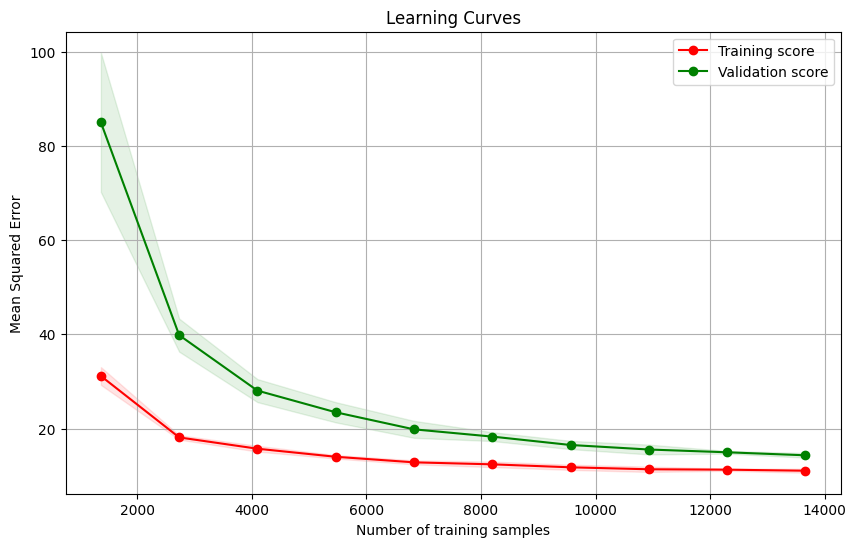

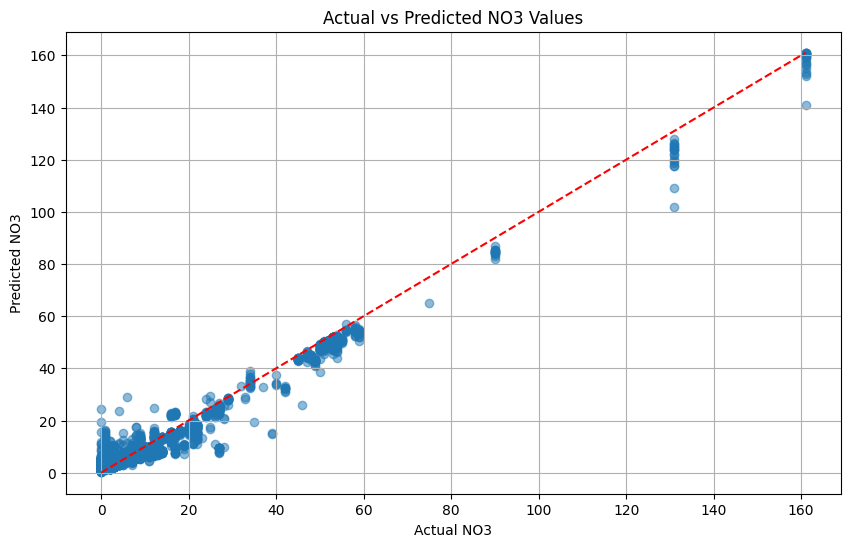

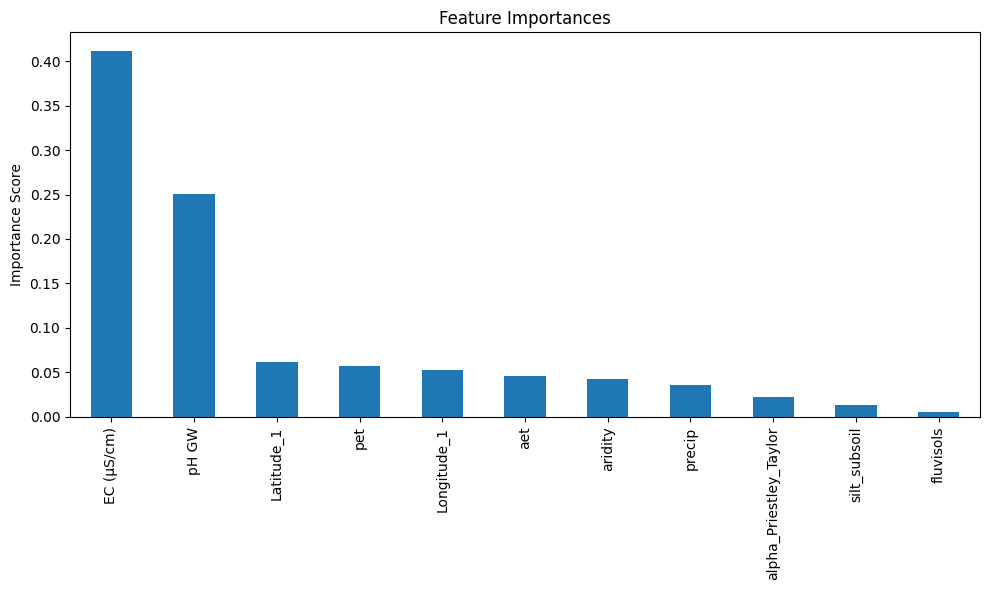

✅ Process completed!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve  # Added train_test_split import
from sklearn.metrics import mean_squared_error, r2_score

# PARAMETERS
input_file = "WORK.xlsx"
target_col = "NO3"
features = [
    'Latitude_1', 'Longitude_1', 'pH GW', 'EC (µS/cm)', 'pet', 
    'precip', 'aridity', 'aet', 'alpha_Priestley_Taylor', 
    'fluvisols', 'silt_subsoil'
]

# Load and preprocess data
def load_and_preprocess(filepath):
    df = pd.read_excel(filepath)
    df = df.replace(-9999, np.nan)
    df = df.dropna(subset=[target_col] + features)
    return df

# Plot learning curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True,
        random_state=42
    )
    
    # Calculate mean and standard deviation
    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
    
    plt.title("Learning Curves")
    plt.xlabel("Number of training samples")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig("learning_curves.png", dpi=300)
    plt.show()

# ========== MAIN EXECUTION ==========
# Load data
df = load_and_preprocess(input_file)
X = df[features]
y = df[target_col]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train model with conservative settings to prevent overfitting
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,            # Limit tree depth
    min_samples_split=5,     # Require more samples to split
    min_samples_leaf=2,      # Require more samples per leaf
    max_features='sqrt',     # Consider fewer features per split
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("Model Performance:")
print(f"Train R²: {train_r2:.2f} | Test R²: {test_r2:.2f}")

# Plot learning curves
print("\nPlotting learning curves...")
plot_learning_curves(model, X_train, y_train)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Actual vs Predicted NO3 Values")
plt.xlabel("Actual NO3")
plt.ylabel("Predicted NO3")
plt.grid(True)
plt.savefig("actual_vs_predicted.png", dpi=300)
plt.show()

# Feature importance
feature_importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importances.png", dpi=300)
plt.show()

print("✅ Process completed!")